In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import os
from six.moves.urllib.request import urlretrieve
import tarfile
import math
import time
from PIL import Image
import imageio

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
HORSE_CATEGORY = 7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


 ship   cat   dog horse


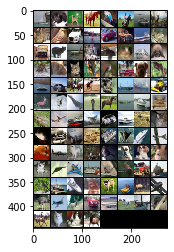

In [3]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
def load_subset(dataset, cls=HORSE_CATEGORY, transpose=False):
    ans = []
    for data in dataset:
        images, labels = data
        msk = labels == cls
        idx = np.nonzero(msk).squeeze()
        ans.append(torch.index_select(images, 0, idx))
    shuffle(ans)
    X = torch.cat(ans)
    if transpose:
        X = X.permute(0, 2, 3, 1)
    return X

In [5]:
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

In [6]:
######################################################################
# Download CIFAR datasets and other related files
######################################################################
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)

data/colours.tar.gz


In [7]:
######################################################################
# Data related code
######################################################################
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if xs.size(0) < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, xs.size(0), batch_size):
        nxt = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(nxt)
    result = torch.cat(nexts)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs.numpy(), 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return torch.from_numpy(cat)

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    grey = xs.mean(axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                        nn.AvgPool2d(2), 
                                        nn.Upsample(scale_factor=2, mode='bilinear'), 
                                        nn.Upsample(scale_factor=2, mode='bilinear'))
        xs_downsized = downsize_module.forward(xs)
        xs_downsized = xs_downsized.detach()
        return (xs, xs_downsized)
    else:
        return (xs, grey)

def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = x.size(0)
    assert N == y.size(0)
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

In [8]:
def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    with torch.no_grad():
        for xs, ys in get_batch(test_grey, test_rgb_cat, batch_size):
            images, labels = xs.to(device), ys.to(device)
            outputs = cnn(images)

            val_loss = compute_loss(criterion,
                                    outputs,
                                    labels,
                                    batch_size=args.batch_size,
                                    num_colours=num_colours)
            losses.append(val_loss.item())
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            total += labels.size(0) * 32 * 32
            correct += predicted.eq(labels).sum()

    if plotpath: # only plot if a path is provided
        plot(xs.numpy(), ys.numpy(), predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [34]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10,:,:,:], [0,2,3,1])
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    if compare_bilinear:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                        nn.AvgPool2d(2), 
                                        nn.Upsample(scale_factor=2, mode='bilinear'), 
                                        nn.Upsample(scale_factor=2, mode='bilinear'))
        gt_input = np.transpose(gtcolor, [0, 3, 1, 2,])
        color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(input[:10,:,:,:], [0,2,3,1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilinear)]
    img = np.vstack(img_stack)
    
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)

def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax)*255).astype(np.uint8))
  
def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True, encoding="bytes")[0]
    num_colours = np.shape(colours)[0]
    
    x_train = load_subset(trainloader)
    x_test = load_subset(testloader)
    
    test_rgb, test_grey = process(x_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)
    
    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + '/act' + str(id)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    images, labels = torch.from_numpy(np.expand_dims(test_grey[id], 0)), \
                     torch.from_numpy(np.expand_dims(test_rgb_cat[id], 0))
    cnn.cpu()
    outputs = cnn(images)
    predicted = torch.argmax(outputs, dim=1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0,0,:,:], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
        img = np.tile(np.transpose(test_grey[id], [1,2,0]), [1,1,3])
    else:
        img = np.transpose(test_grey[id].numpy(), [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id].numpy(), [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d_gt.png" % id))

    
    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack([
            np.hstack([
                add_border(filter) for filter in
                activation[i*imgwidth:(i+1)*imgwidth,:,:]])
            for i in range(activation.shape[0] // imgwidth)])
        imageio.imwrite(path, img)


    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i+1, id)),
            tensor.data.cpu().numpy()[0])
    print("visualization results are saved to %s"%outdir)

In [10]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    torch.manual_seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True, encoding="bytes")[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        if args.model == "CNN":
            cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
        elif args.model == "UNet":
            cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    x_train = load_subset(trainloader)
    x_test = load_subset(testloader)

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    cnn.to(device)
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for xs, ys in get_batch(train_grey,train_rgb_cat,args.batch_size):
            images, labels = xs.to(device), ys.to(device)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        # plot training images
        if args.plot:
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            plot(xs.numpy(), ys.numpy(), predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %d' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

In [11]:
######################################################################
# MODELS
######################################################################

class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        ############### YOUR CODE GOES HERE ###############
        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters, num_colours, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(num_colours, num_colours, kernel_size=kernel)
        ###################################################

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(self.out3)
        self.out5 = self.upconv2(self.out4)
        self.out_final = self.finalconv(self.out5)
        return self.out_final

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()
        padding = kernel // 2
        ############### YOUR CODE GOES HERE ############### 
        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size = kernel, padding = padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters * 2, kernel_size = kernel,
                      padding = padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())
        self.rfconv = nn.Sequential(
            MyConv2d(num_filters * 2, num_filters * 2, kernel_size = kernel,
                      padding = padding),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())
        self.upconv1 = nn.Sequential(
            MyConv2d(4 * num_filters, num_filters, kernel_size = kernel,
                      padding = padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())
        self.upconv2 = nn.Sequential(
            MyConv2d(2 * num_filters, num_colours, kernel_size = kernel, padding = padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU())
        self.finalconv = MyConv2d(num_colours + num_in_channels, num_colours, kernel_size = kernel)
        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(torch.cat((self.out2, self.out3), 1))
        self.out5 = self.upconv2(torch.cat((self.out1, self.out4), 1))
        self.out_final = self.finalconv(torch.cat((self.out5, x), 1))
        return self.out_final
        ###################################################

Loading data...
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4696, Time (s): 15
Epoch [1/25], Val Loss: 2.1524, Val Acc: 27.1%, Time(s): 16
Epoch [2/25], Loss: 2.0160, Time (s): 31
Epoch [2/25], Val Loss: 1.9567, Val Acc: 31.0%, Time(s): 32
Epoch [3/25], Loss: 1.8951, Time (s): 48
Epoch [3/25], Val Loss: 1.8678, Val Acc: 33.3%, Time(s): 49
Epoch [4/25], Loss: 1.8307, Time (s): 64
Epoch [4/25], Val Loss: 1.8212, Val Acc: 34.4%, Time(s): 65
Epoch [5/25], Loss: 1.7907, Time (s): 80
Epoch [5/25], Val Loss: 1.7932, Val Acc: 35.1%, Time(s): 82
Epoch [6/25], Loss: 1.7633, Time (s): 97
Epoch [6/25], Val Loss: 1.7635, Val Acc: 35.9%, Time(s): 98
Epoch [7/25], Loss: 1.7394, Time (s): 113
Epoch [7/25], Val Loss: 1.7435, Val Acc: 36.4%, Time(s): 114
Epoch [8/25], Loss: 1.7198, Time (s): 129
Epoch [8/25], Val Loss: 1.7284, Val Acc: 36.9%, Time(s): 131
Epoch [9/25], Loss: 1.7029, Time (s): 146
Epoch [9/25], Val Loss: 1.7039, Val Acc: 37.6%, Time(s): 147
Epoch [10/25], Loss: 1.68

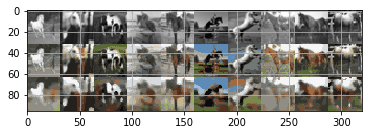

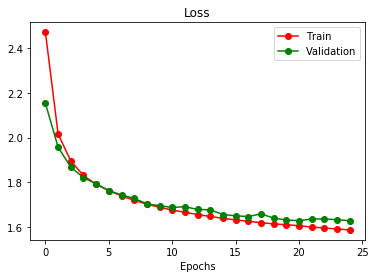

In [12]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':20200207,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

Loading data...
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.3438, Time (s): 19
Epoch [1/25], Val Loss: 2.0187, Val Acc: 31.9%, Time(s): 21
Epoch [2/25], Loss: 1.8639, Time (s): 39
Epoch [2/25], Val Loss: 1.7605, Val Acc: 37.3%, Time(s): 41
Epoch [3/25], Loss: 1.7367, Time (s): 60
Epoch [3/25], Val Loss: 1.7031, Val Acc: 37.3%, Time(s): 61
Epoch [4/25], Loss: 1.6660, Time (s): 80
Epoch [4/25], Val Loss: 1.6624, Val Acc: 38.0%, Time(s): 81
Epoch [5/25], Loss: 1.6157, Time (s): 100
Epoch [5/25], Val Loss: 1.6288, Val Acc: 38.8%, Time(s): 102
Epoch [6/25], Loss: 1.5761, Time (s): 121
Epoch [6/25], Val Loss: 1.5771, Val Acc: 40.7%, Time(s): 122
Epoch [7/25], Loss: 1.5445, Time (s): 140
Epoch [7/25], Val Loss: 1.5488, Val Acc: 41.7%, Time(s): 142
Epoch [8/25], Loss: 1.5155, Time (s): 159
Epoch [8/25], Val Loss: 1.5231, Val Acc: 42.5%, Time(s): 161
Epoch [9/25], Loss: 1.4900, Time (s): 179
Epoch [9/25], Val Loss: 1.5077, Val Acc: 42.9%, Time(s): 181
Epoch [10/25], Loss: 

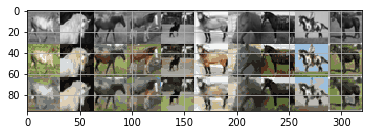

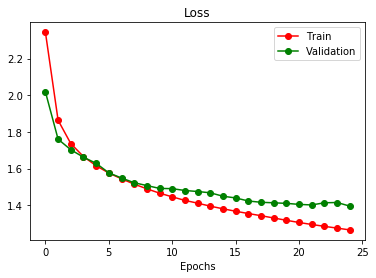

In [13]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':20200207,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

Loading data...
Transforming data...


/Users/heqingye/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Beginning training ...
Epoch [1/25], Loss: 2.2990, Time (s): 15
Epoch [1/25], Val Loss: 2.0138, Val Acc: 31.0%, Time(s): 16
Epoch [2/25], Loss: 1.7442, Time (s): 31
Epoch [2/25], Val Loss: 1.7294, Val Acc: 39.4%, Time(s): 32
Epoch [3/25], Loss: 1.6482, Time (s): 47
Epoch [3/25], Val Loss: 1.6388, Val Acc: 42.4%, Time(s): 48
Epoch [4/25], Loss: 1.6068, Time (s): 63
Epoch [4/25], Val Loss: 1.5873, Val Acc: 44.0%, Time(s): 65
Epoch [5/25], Loss: 1.5821, Time (s): 80
Epoch [5/25], Val Loss: 1.5704, Val Acc: 44.5%, Time(s): 81
Epoch [6/25], Loss: 1.5665, Time (s): 97
Epoch [6/25], Val Loss: 1.5600, Val Acc: 44.7%, Time(s): 98
Epoch [7/25], Loss: 1.5548, Time (s): 113
Epoch [7/25], Val Loss: 1.5568, Val Acc: 44.7%, Time(s): 114
Epoch [8/25], Loss: 1.5455, Time (s): 130
Epoch [8/25], Val Loss: 1.5475, Val Acc: 45.0%, Time(s): 131
Epoch [9/25], Loss: 1.5373, Time (s): 147
Epoch [9/25], Val Loss: 1.5428, Val Acc: 45.1%, Time(s): 148
Epoch [10/25], Loss: 1.5303, Time (s): 164
Epoch [10/25], Val 

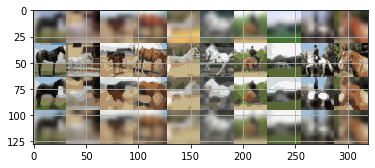

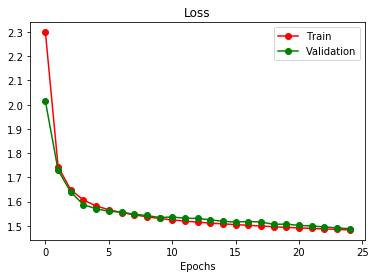

In [14]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':20200207,
              'plot':True, 
              'experiment_name': 'super_res_unet',
              'visualize': False,
              'downsize_input':True,
}
args.update(args_dict)
sr_cnn = train(args)

In [35]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_cnn',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args, cnn)

visualization results are saved to outputs/colourization_cnn/act0


In [36]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_unet',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args, unet_cnn)

RuntimeError: DataLoader worker (pid 35801) is killed by signal: Unknown signal: 0. 

In [37]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'super_res_unet',
              'downsize_input':True,
}
args.update(args_dict)
plot_activation(args, sr_cnn)

RuntimeError: DataLoader worker (pid 35808) is killed by signal: Unknown signal: 0. 